In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%qtconsole --colors=linux
plt.style.use('ggplot')

# Chapter 4 - Inferences with Gaussians
## 4.1 Inferring a mean and standard deviation


Inferring the mean and variance of a Gaussian distribution. 
$$ \mu \sim \text{Gaussian}(0, .001)  $$
$$ \sigma \sim \text{Uniform} (0, 10)  $$
$$ x_{i} \sim \text{Gaussian} (\mu, \frac{1}{\sigma^2})  $$


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -10.249: 100%|██████████| 200000/200000 [00:08<00:00, 23573.90it/s]
Finished [100%]: Average ELBO = -10.251
100%|██████████| 1000/1000 [00:00<00:00, 1871.91it/s]


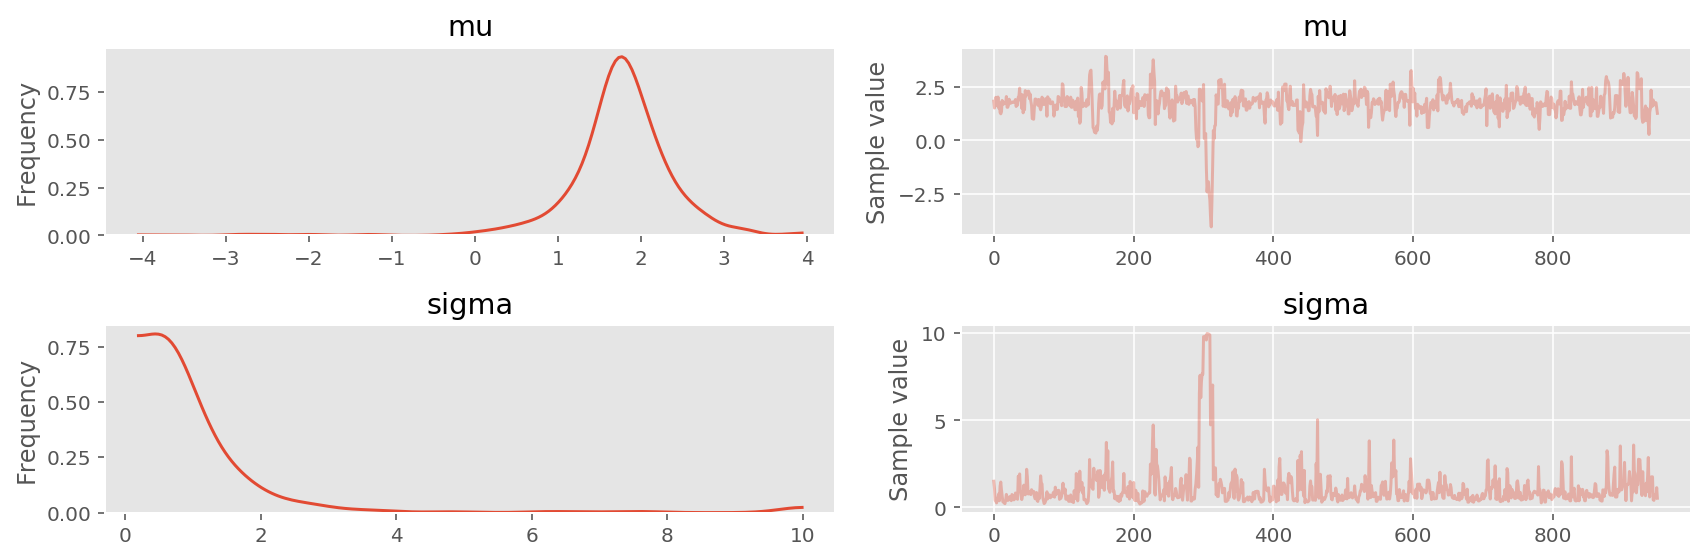

In [2]:
# Data
x = np.array([1.1, 1.9, 2.3, 1.8])
n = len(x)
    
with pm.Model() as model1:
    # prior
    mu = pm.Normal('mu', mu=0, tau=.001)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    # observed
    xi = pm.Normal('xi',mu=mu, tau=1/(sigma**2), observed=x)
    # inference
    trace = pm.sample(1000, njobs=1)

pm.traceplot(trace[50:]);

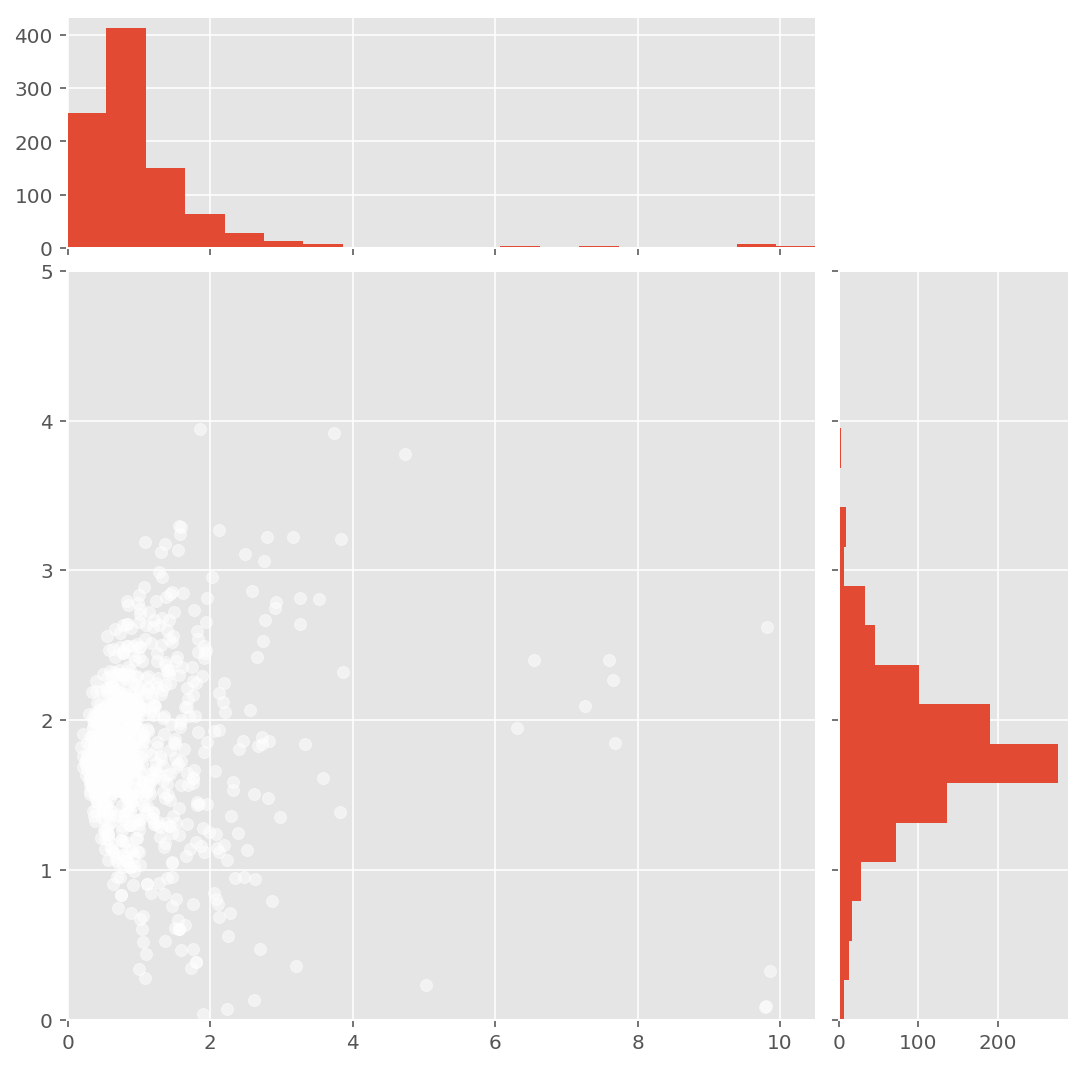

The mu estimation is:  1.72942445016
The sigma estimation is:  1.12149982049


In [3]:
from matplotlib.ticker import NullFormatter
nullfmt = NullFormatter()         # no labels
y = trace['mu'][50:]
x = trace['sigma'][50:]

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(1, figsize=(8, 8))

axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

# no labels
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)

# the scatter plot:
axScatter.scatter(x, y, c=[1, 1, 1], alpha=.5)

# now determine nice limits by hand:
binwidth1 = 0.25
axScatter.set_xlim((-.01, 10.5))
axScatter.set_ylim((-0, 5))

bins1 = np.linspace(-.01, 10.5, 20)
axHistx.hist(x, bins=bins1)
bins2 = np.linspace(-0, 5, 20)
axHisty.hist(y, bins=bins2, orientation='horizontal')

axHistx.set_xlim(axScatter.get_xlim())
axHisty.set_ylim(axScatter.get_ylim())

plt.show()
print('The mu estimation is: ', y.mean())
print('The sigma estimation is: ', x.mean())


## 4.2 The seven scientists


The model:
$$ \mu \sim \text{Gaussian}(0, .001)  $$
$$ \lambda_{i} \sim \text{Gamma} (.001, .001)  $$
$$ \sigma = 1/{\sqrt\lambda_{i}} $$  
$$ x_{i} \sim \text{Gaussian} (\mu, \lambda_{i})  $$

The mean is the same for all seven scientists, while the standard deviations are different 

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -41.721: 100%|██████████| 200000/200000 [00:08<00:00, 24379.42it/s]
Finished [100%]: Average ELBO = -41.955
100%|██████████| 5000/5000 [00:07<00:00, 668.71it/s]


The mu estimation is:  9.86598191794
The sigma estimation is: 
36.6680125745
6.24278875242
1.41257987883
0.180650664163
0.261064370776
0.179279062845
0.205564711789


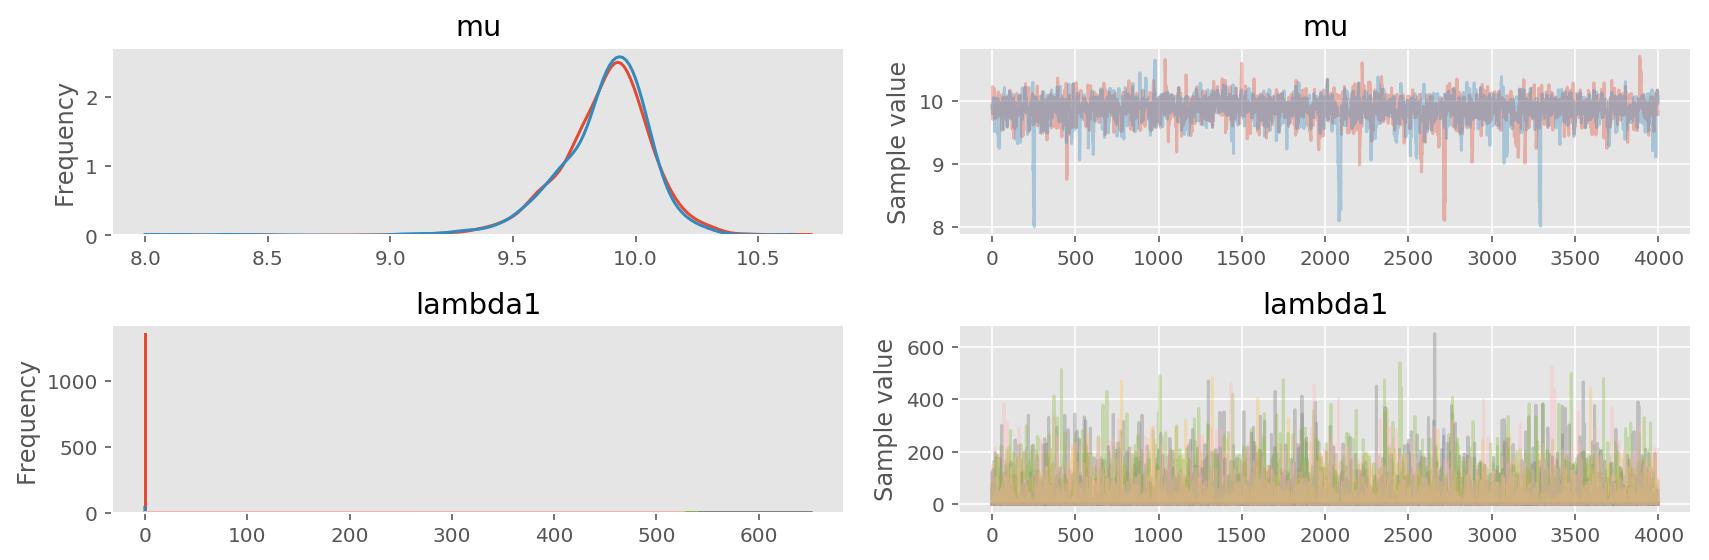

In [8]:
# data
x = np.array([-27.020,3.570,8.191,9.898,9.603,9.945,10.056])
n = len(x)

with pm.Model() as model2: 
    # prior
    mu = pm.Normal('mu', mu=0, tau=.001)
    lambda1 = pm.Gamma('lambda1', alpha=.01, beta=.01, shape=(n))
    # sigma = pm.Deterministic('sigma',1 / sqrt(lambda1))
    # observed
    xi = pm.Normal('xi',mu = mu, tau = lambda1, observed = x )

    # inference
    trace2 = pm.sample(5000, njobs=2)

burnin = 1000
pm.traceplot(trace2[burnin:]);

mu = trace2['mu'][burnin:]
lambda1 = trace2['lambda1'][burnin:]

print('The mu estimation is: ', mu.mean())
print('The sigma estimation is: ')
for i in np.mean(np.squeeze(lambda1),axis=0):
    print(1 / np.sqrt(i))

## 4.3 Repeated measurement of IQ


The model:
$$ \mu_{i} \sim \text{Uniform}(0, 300)  $$
$$ \sigma \sim \text{Uniform} (0, 100)  $$
$$ x_{ij} \sim \text{Gaussian} (\mu_{i}, \frac{1}{\sigma^2})  $$

Data Come From Gaussians With Different Means But Common Precision

In [34]:
# Data
y = np.array([[90,95,100],[105,110,115],[150,155,160]])
ntest = 3
nsbj = 3

import sys
eps = sys.float_info.epsilon

with pm.Model() as model3:
    # mu_i ~ Uniform(0, 300)
    mui = pm.Uniform('mui', 0, 300, shape=(nsbj,1))

    # sg ~ Uniform(0, 100)
    # sg = pm.Uniform('sg', .0, 100)
    
    # It is more stable to use a Gamma prior
    lambda1 = pm.Gamma('lambda1', alpha=.01, beta=.01)
    sg = pm.Deterministic('sg',1 / np.sqrt(lambda1))
    
    # y ~ Normal(mu_i, sg)
    yd = pm.Normal('y', mu=mui, sd=sg, observed=y)
    
    trace3 = pm.sample(5e3, njobs=2)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -41.53: 100%|██████████| 200000/200000 [00:11<00:00, 18158.22it/s] 
Finished [100%]: Average ELBO = -41.519
100%|██████████| 5000/5000.0 [00:05<00:00, 901.83it/s]


The mu estimation is:  [[  95.04121864]
 [ 109.90825302]
 [ 154.89354047]]
The sigma estimation is:  5.66237365181


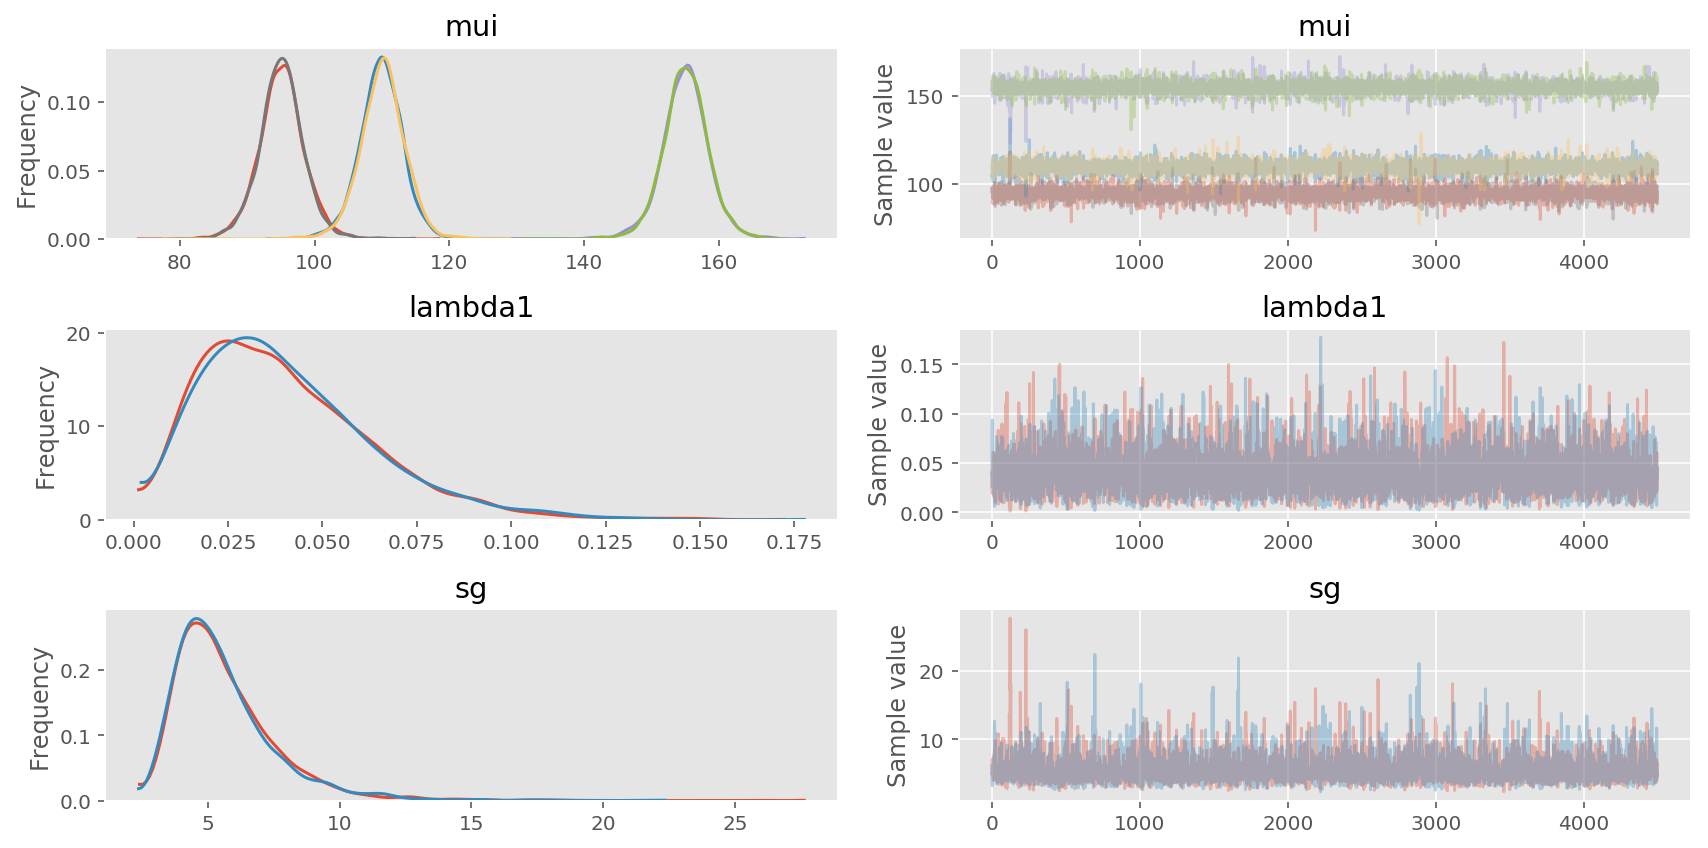

In [35]:
burnin = 500
pm.traceplot(trace3[burnin:]);

mu = trace3['mui'][burnin:]
sigma = trace3['sg'][burnin:]

print('The mu estimation is: ', np.mean(mu, axis=0))
print('The sigma estimation is: ',sigma.mean())